In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

import pickle
import finesse
from scipy.optimize import minimize
from finesse.gaussian import BeamParam
import matplotlib.colors as colors
import scipy
from scipy.optimize import curve_fit
from scipy import interpolate

finesse.configure(plotting=True)
import warnings
warnings.filterwarnings('ignore')

### Beam-expanding telescopes **INSIDE** CE arms:

In [2]:
variables = """
# ------------------------------------------------------------------------------
# variables
# ------------------------------------------------------------------------------
variable nsilica 1.44963098985906
variable Mloss 30u

variable L_ARM 40k
variable TM_Rc 25.2049k

variable PRMRc 50
variable SEMRc -50
variable l_PRM_BS 50
variable l_BS_SEM 50

variable l_BS_XM2 50
variable XM2Rc -50
variable l_XM2_XM3 50
variable XM3Rc 50

variable l_XM3_ITMXlens 50

variable ITMX_lensf 10k
"""

In [3]:
base = finesse.Model()
base.parse(variables)
base.parse("""
l l1 P=165
s ll1_PRM l1.p1 PRMAR.p1

# ------------------------------------------------------------------------------
# Power recycling cavity
# ------------------------------------------------------------------------------
m PRMAR R=0 T=0.99996 # compound mirrors PRM, ITMX, and SEM
s sPRMsub PRMAR.p2 PRM.p1 L=0.0737 nr=&nsilica
m PRM R=0.9699915 T=0.03 Rc=PRMRc
s lPRM_BS PRM.p2 BS.p1 L=l_PRM_BS

bs BS R=0.5 T=0.5
# ------------------------------------------------------------------------------
# Y-arm
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# X-arm
# ------------------------------------------------------------------------------
s lBS_XM2 BS.p3 XM2.p1 L=l_BS_XM2
bs XM2 T=250u L=37.5u alpha=-1 Rc=XM2Rc
s lXM2_XM3 XM2.p2 XM3.p1 L=l_XM2_XM3
bs XM3 T=0 L=37.5u alpha=1 Rc=XM3Rc
s lXM3_ITMXlens XM3.p2 ITMX_lens.p1 L=l_XM3_ITMXlens

lens ITMX_lens ITMX_lensf

s lITMX ITMX_lens.p2 ITMXAR.p1

m ITMXAR T=0.99998 L=20u
s sITMXsub1 ITMXAR.p2 ITMX.p1 L=0.4 nr=nsilica
m ITMX T=0.014 L=Mloss phi=0 Rc=-TM_Rc

s LY ITMX.p2 ETMX.p1 L=L_ARM
m ETMX T=5u L=Mloss phi=0 Rc=TM_Rc

cav cavXARM source=ITMX.p2.o via=ETMX.p1.i priority=2
#cav cavPRX PRM.p2.o via=ITMX.p1.i priority=1
# ------------------------------------------------------------------------------
# Sginal recycling cavity
# ------------------------------------------------------------------------------
s lBS_SEM BS.p4 SEM.p1 L=l_BS_SEM
m SEM R=0.7999913 T=0.2 L=8.7u Rc=SEMRc
s SEMsub SEM.p2 SEMAR.p1 L=0.0749 nr=nsilica
m SEMAR R=0 T=0.99999995 L=50n
# ------------------------------------------------------------------------------
# Output optics
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# Power detectors
# ------------------------------------------------------------------------------
"""
)

The SEM RoC is -79.5919


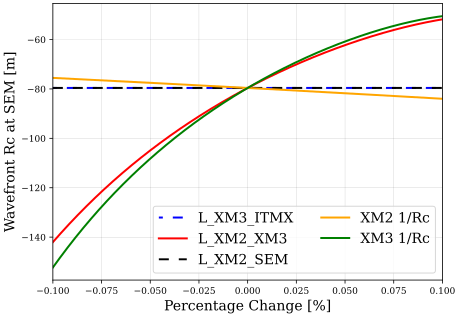

In [4]:
kat = base.deepcopy()

l_XM3_ITMXlens = 100
l_XM2_XM3 = 45.5
l_BS_XM2 = 50
l_BS_SEM = 30

XM2Rc = -9.6
XM3Rc = 100
ITMX_lensf = np.inf

SEMRc = -79.59188
PRMRc = 50
l_PRM_BS = 50

kat.PRMRc.value = PRMRc
kat.SEMRc.value = SEMRc
kat.l_PRM_BS.value = l_PRM_BS
kat.l_BS_SEM.value = l_BS_SEM
kat.l_BS_XM2.value = l_BS_XM2
kat.XM2Rc.value = XM2Rc
kat.l_XM2_XM3.value = l_XM2_XM3
kat.XM3Rc.value = XM3Rc
kat.l_XM3_ITMXlens.value = l_XM3_ITMXlens
kat.ITMX_lensf.value = ITMX_lensf

katt = kat.deepcopy()

ITMX_TO_SEM = katt.path(katt.ITMX.p1, katt.SEM.p1)
SEC_ps_sym = katt.propagate_beam(path=ITMX_TO_SEM, symbolic=True)
Rc_SEM_1_sym = SEC_ps_sym.q(katt.SEM.p1.i).Rc
print(f"The SEM RoC is {Rc_SEM_1_sym.eval():.4f}")
xrange = np.linspace(-0.01, 0.01, 500)/10
xrange_xaxis = xrange*100

# K = 1/ITMX_lensf
# Krange = K*(1 - xrange)
# ITMXlensf_range = 1/Krange
# Rc_SEM_1_val = Rc_SEM_1_sym.eval(subs={'ITMX_lens.f': ITMXlensf_range}) 

XM3_ITMXlensl_range = l_XM3_ITMXlens*(1 + xrange)
Rc_SEM_2_val = Rc_SEM_1_sym.eval(subs={'lXM3_ITMXlens.L': XM3_ITMXlensl_range}) 

XM2XM3l_range = l_XM2_XM3*(1 + xrange)
Rc_SEM_3_val = Rc_SEM_1_sym.eval(subs={'lXM2_XM3.L': XM2XM3l_range}) 

BS_SEMl_range = l_BS_SEM*(1 + xrange)
Rc_SEM_4_val = Rc_SEM_1_sym.eval(subs={'lBS_SEM.L': BS_SEMl_range}) 

XM2S_range = (1/XM2Rc)*(1 + xrange)
XM2Rc_range = 1/XM2S_range
Rc_SEM_5_val = Rc_SEM_1_sym.eval(subs={'XM2.Rcx': XM2Rc_range}) 

XM3S_range = (1/XM3Rc)*(1 + xrange)
XM3Rc_range = 1/XM3S_range
Rc_SEM_6_val = Rc_SEM_1_sym.eval(subs={'XM3.Rcx': XM3Rc_range}) 

fig, ax = plt.subplots(figsize=(7, 5))

# ax.plot(xrange_xaxis, Rc_SEM_1_val, lw=2, label="ITMX_lens 1/f", ls=(5, (5, 5)))
ax.plot(xrange_xaxis, Rc_SEM_2_val, lw=2, label="L_XM3_ITMX", ls=(3, (5, 5)))
ax.plot(xrange_xaxis, Rc_SEM_3_val, lw=2, label="L_XM2_XM3")
ax.plot(xrange_xaxis, Rc_SEM_4_val, lw=2, label="L_XM2_SEM", ls=(0, (5, 5)))
ax.plot(xrange_xaxis, Rc_SEM_5_val, lw=2, label="XM2 1/Rc")
ax.plot(xrange_xaxis, Rc_SEM_6_val, lw=2, label="XM3 1/Rc")

ax.set_xlabel("Percentage Change [%]", fontsize=14)
ax.set_ylabel("Wavefront Rc at SEM [m]", fontsize=14)

ax.legend(loc="best", ncol=2, fontsize=14);

# fig.savefig('Figures/Five_dofs.pdf', bbox_inches='tight', dpi=120, pad_inches=0.01);

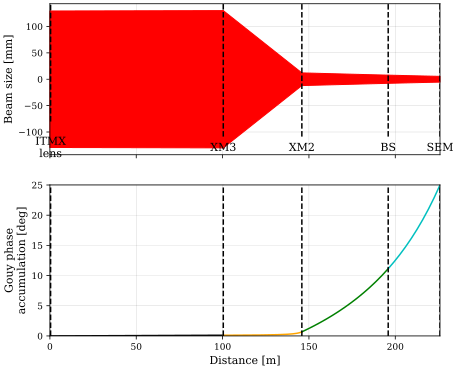

SEC RoC is -79.59188167303567


In [5]:
pb_SEC = katt.propagate_beam(path=ITMX_TO_SEM)
fig, axes = pb_SEC.plot(figsize=(7, 3));
SEM_Rc_fixed = pb_SEC.q(katt.SEM.p1.i).Rc
print(f"SEC RoC is {SEM_Rc_fixed}")
# fig.savefig('Figures/CE_bp.pdf', bbox_inches='tight', dpi=120, pad_inches=0.01);

In [6]:
def L_XM2XM3_given_XM3Rc_XM2Rc(XM3Rc, rangee=0.003):
    L_XM2XM3 = 0.5*XM3Rc-4.48
    return L_XM2XM3*(1-rangee), L_XM2XM3*(1+rangee)

def L_XM2XM3_given_XM3Rc_XM2Rc_n(XM3Rc, rangee=0.003):
    L_XM2XM3 = 0.5*XM3Rc-4.83
    return L_XM2XM3*(1-rangee), L_XM2XM3*(1+rangee)

def L_XM2XM3_given_XM3Rc_XM2Rc_p(XM3Rc, rangee=0.003):
    L_XM2XM3 = 0.5*XM3Rc-4.1
    return L_XM2XM3*(1-rangee), L_XM2XM3*(1+rangee)

In [7]:
shape = 300
interorder = 3
shape_expand = shape*interorder
xrange = np.linspace(-0.04, 0.05, shape)
XM3S_range = (1/100)*(1 + xrange)
XM3Rc_range = 1/XM3S_range
def zoomedin_parameter_space(XM2Rc=-9.6):
    Rc_SEMs = []
    Gouy_SECs = []
    SEMws = []
    BSws = []
    for XM3Rc in XM3Rc_range: 
        if XM2Rc==-9.6:
            range1, range2 = L_XM2XM3_given_XM3Rc_XM2Rc(XM3Rc)
        elif XM2Rc==-8.8:
            range1, range2 = L_XM2XM3_given_XM3Rc_XM2Rc_p(XM3Rc)
        elif XM2Rc==-10.4:
            range1, range2 = L_XM2XM3_given_XM3Rc_XM2Rc_n(XM3Rc)

        L_XM2XM3_range = np.linspace(range1, range2, shape)
        
        kat_ = kat.deepcopy()
        kat_.XM2Rc.value = XM2Rc
        kat_.XM3Rc.value = XM3Rc

        ITMX_TO_SEM = kat_.path(kat_.ITMX.p1, kat_.SEM.p1)
        SEC_ps = kat_.propagate_beam(path=ITMX_TO_SEM, symbolic=True)
        Rc_SEM_sym = SEC_ps.q(kat_.SEM.p1.i).Rc
        Gouy_SEC_sym = SEC_ps.acc_gouy("lXM3_ITMXlens", "lXM2_XM3", "lBS_XM2", "lBS_SEM")
        SEMw_sym = SEC_ps.q(kat_.SEM.p1.i).w
        BSw_sym = SEC_ps.q(kat_.BS.p3.i).w
        
        Rc_SEM = Rc_SEM_sym.eval(subs={'lXM2_XM3.L': L_XM2XM3_range}) 
        Gouy_SEC = Gouy_SEC_sym.eval(subs={'lXM2_XM3.L': L_XM2XM3_range}) 
        SEMw = SEMw_sym.eval(subs={'lXM2_XM3.L': L_XM2XM3_range}) 
        BSw = BSw_sym.eval(subs={'lXM2_XM3.L': L_XM2XM3_range}) 

        Rc_SEMs.append(Rc_SEM)
        Gouy_SECs.append(Gouy_SEC)
        SEMws.append(SEMw)
        BSws.append(BSw)

    Rc_SEMs = np.array(Rc_SEMs)
    Gouy_SECs = np.array(Gouy_SECs)
    SEMws = np.array(SEMws)
    BSws = np.array(BSws)

    return Rc_SEMs, Gouy_SECs, SEMws, BSws

def zoomedin_parameter_space_plot(Rc_SEMs, Gouy_SECs, SEMws, BSws, plot=True):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(9, 8.5))

    S_SEMs = 1/Rc_SEMs
    S_SEMs_inter = scipy.ndimage.zoom(S_SEMs.T, interorder)
    Gouy_SECs_inter = scipy.ndimage.zoom(Gouy_SECs.T, interorder)
    SEMws_inter = scipy.ndimage.zoom(SEMws.T, interorder)
    BSws_inter = scipy.ndimage.zoom(BSws.T, interorder)

    ax1.get_xaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    ax3.get_xaxis().set_visible(False)
    ax4.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    ax4.get_yaxis().set_visible(False)
    
    ax1.set_title("XM3.Rc - XM2XM3.L \n Parameter Space", fontsize=17, fontweight='bold', pad=22)
    
    contours1 = ax1.contour(S_SEMs_inter, [1/SEM_Rc_fixed], colors=["r"], alpha=0)
    
    paths = contours1.collections[0].get_paths()
    v1 = paths[0].vertices
    x1 = v1[:,0]
    y1 = v1[:,1]
    ax1.plot(x1, y1, "r--")
    ax2.plot(x1, y1, "r--")
    ax3.plot(x1, y1, "r--")
    ax4.plot(x1, y1, "r--")
    
    v2 = paths[1].vertices
    x2 = v2[:,0]
    y2 = v2[:,1]
    # print(y1[:5])
    ax1.plot(x2, y2, "b--")
    ax2.plot(x2, y2, "b--")
    ax3.plot(x2, y2, "b--")
    ax4.plot(x2, y2, "b--")
        
    ax2_top = ax2.inset_axes([0, 1.05, 1, 0.25], sharex=ax2)
    ax2_top_twin = ax2_top.twinx()
    x = y = np.arange(shape_expand)
    f_Gouy_SECs_inter = interpolate.interp2d(x, y, Gouy_SECs_inter, kind='cubic')
    data1 = f_Gouy_SECs_inter(x1, y1)[0]
    data2 = f_Gouy_SECs_inter(x2, y2)[0]
    # print(len(data1))
    # print(len(data2))
    ax2_top.plot(np.linspace(0, shape_expand, len(data1)), data1, "r--")
    ax2_top_twin.plot(np.linspace(0, shape_expand, len(data2)), data2, "b--")
    ymin, ymax = data1.min()*0.98, data1.max()*1.02
    ymin_t, ymax_t = data2.min()*0.97, data2.max()*1.03
    ax2_top.set_ylim([ymin, ymax])
    ax2_top_twin.set_ylim([ymin_t, ymax_t])
    ax2_top.tick_params(axis='y', labelcolor="r", color="r")
    ax2_top_twin.tick_params(axis='y', labelcolor="b", color="b")
    ax2_top_twin.set_ylabel("Gouy Phase \n[deg]", fontsize=10)
    ax2_top.get_xaxis().set_visible(False)

    ax3_top = ax3.inset_axes([0, -0.3, 1, 0.25], sharex=ax3)
    ax3_top_twin = ax3_top.twinx()
    x = y = np.arange(shape_expand)
    f_SEMws_inter = interpolate.interp2d(x, y, SEMws_inter, kind='cubic')
    data1 = f_SEMws_inter(x1, y1)[0]
    data2 = f_SEMws_inter(x2, y2)[0]
    ax3_top.plot(np.linspace(0, shape_expand, len(data1)), data1, "r--")
    ax3_top_twin.plot(np.linspace(0, shape_expand, len(data2)), data2, "b--")
    ymin, ymax = data1.min()*0.95, data1.max()*1.05
    ymin_t, ymax_t = data2.min()*0.97, data2.max()*1.03
    ax3_top.set_ylim([ymin, ymax])
    ax3_top_twin.set_ylim([ymin_t, ymax_t])
    ax3_top.tick_params(axis='y', labelcolor="r", color="r")
    ax3_top_twin.tick_params(axis='y', labelcolor="b", color="b")
    ax3_top.set_ylabel("SEM w \n[mm]")
    ax3_top.get_xaxis().set_visible(False)
    
    ax4_top = ax4.inset_axes([0, -0.3, 1, 0.25], sharex=ax2)
    ax4_top_twin = ax4_top.twinx()
    x = y = np.arange(shape_expand)
    f_BSws_inter = interpolate.interp2d(x, y, BSws_inter, kind='cubic')
    data1 = f_BSws_inter(x1, y1)[0]
    data2 = f_BSws_inter(x2, y2)[0]
    ax4_top.plot(np.linspace(0, shape_expand, len(data1)), data1, "r--")
    ax4_top_twin.plot(np.linspace(0, shape_expand, len(data2)), data2, "b--")
    ymin, ymax = data1.min()*0.98, data1.max()*1.02
    ymin_t, ymax_t = data2.min()*0.995, data2.max()*1.005
    ax4_top.set_ylim([ymin, ymax])
    ax4_top_twin.set_ylim([ymin_t, ymax_t])
    ax4_top.tick_params(axis='y', labelcolor="r", color="r")
    ax4_top_twin.tick_params(axis='y', labelcolor="b", color="b")
    ax4_top_twin.set_ylabel("BS w \n[mm]")
    ax4_top.get_xaxis().set_visible(False)
    
    if plot:
        im1 = ax1.pcolormesh(S_SEMs_inter, cmap='viridis')
        im2 = ax2.pcolormesh(Gouy_SECs_inter, cmap='viridis')
        im3 = ax3.pcolormesh(SEMws_inter, cmap='viridis')
        im4 = ax4.pcolormesh(BSws_inter, cmap='viridis')

        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('left', size='5%', pad=0.1)
        cbar = fig.colorbar(im1, cax=cax, ticklocation="left", orientation='vertical')
        cbar.set_label(label="SEM 1/Rc [1/m]", fontsize=16, rotation=90, labelpad=2)

        divider = make_axes_locatable(ax2)
        cax = divider.append_axes('right', size='5%', pad=0.1)
        cbar = fig.colorbar(im2, cax=cax, orientation='vertical')
        cbar.set_label(label="Gouy Phase [deg]", fontsize=16, rotation=90, labelpad=2)

        divider = make_axes_locatable(ax3)
        cax = divider.append_axes('left', size='5%', pad=0.1)
        cbar = fig.colorbar(im3, cax=cax, ticklocation="left", orientation='vertical')
        cbar.set_label(label="SEM w [mm]", fontsize=16, rotation=90, labelpad=2)

        divider = make_axes_locatable(ax4)
        cax = divider.append_axes('right', size='5%', pad=0.1)
        cbar = fig.colorbar(im4, cax=cax, orientation='vertical')
        cbar.set_label(label="BS w [mm]", fontsize=16, rotation=90, labelpad=2);

    return contours1

In [8]:
Rc_SEMs_0, Gouy_SECs_0, SEMws_0, BSws_0 = zoomedin_parameter_space(XM2Rc=-9.6)
Rc_SEMs_1, Gouy_SECs_1, SEMws_1, BSws_1 = zoomedin_parameter_space(XM2Rc=-10.4)
Rc_SEMs_2, Gouy_SECs_2, SEMws_2, BSws_2 = zoomedin_parameter_space(XM2Rc=-8.8)

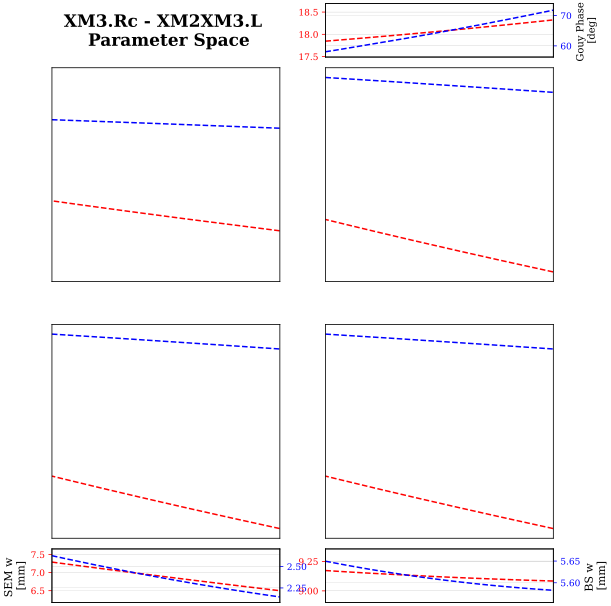

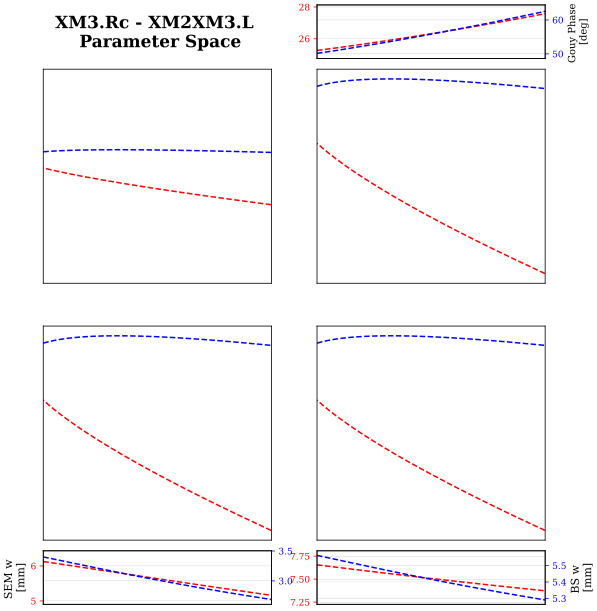

In [9]:
contours_1 = zoomedin_parameter_space_plot(Rc_SEMs_1, Gouy_SECs_1, 1e3*np.array(SEMws_1), 1e3*np.array(BSws_1), plot=False)
contours_2 = zoomedin_parameter_space_plot(Rc_SEMs_2, Gouy_SECs_2, 1e3*np.array(SEMws_2), 1e3*np.array(BSws_2), plot=False)

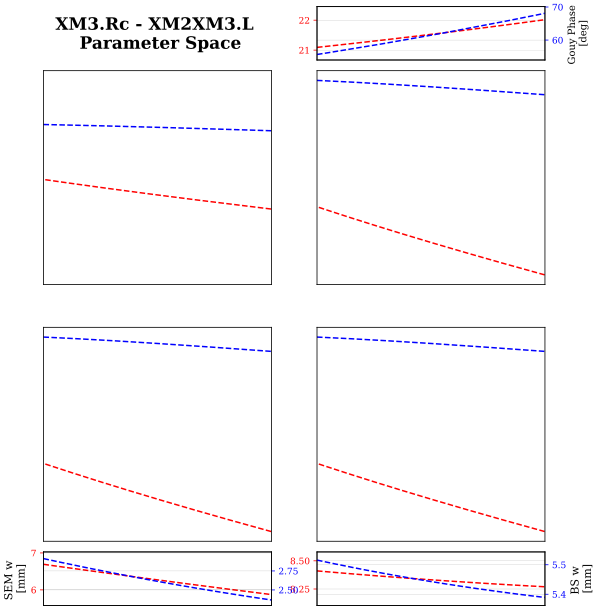

In [10]:
contours_0 = zoomedin_parameter_space_plot(Rc_SEMs_0, Gouy_SECs_0, 1e3*np.array(SEMws_0), 1e3*np.array(BSws_0), plot=False)
# fig = plt.gcf()
# fig.savefig('Figures/parameter_space_micro.pdf', bbox_inches='tight', dpi=120, pad_inches=0.01);

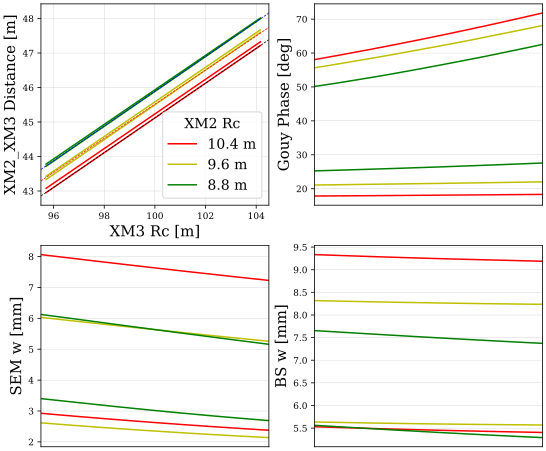

In [11]:
def XM3Rc_f(idx):
    x = -0.04 + (0.05--0.035)/shape_expand*idx
    XM3S = (1/100)*(1 + x)
    XM3Rc = 1/XM3S
    
    return XM3Rc

fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(2, 2, figsize=(9, 8))

Gouy_phases = [scipy.ndimage.zoom(Gouy_SECs_1.T, interorder), scipy.ndimage.zoom(Gouy_SECs_0.T, interorder), 
               scipy.ndimage.zoom(Gouy_SECs_2.T, interorder)]
contours = [contours_1, contours_0, contours_2]
colors = ["r", "y", "g"]
labels = ["10.4 m", "9.6 m", "8.8 m"]

contour_lines = []
for idx, (contour, label) in enumerate(zip(contours, labels)):
    for ip, path in enumerate(contour.collections[0].get_paths()):
        v = path.vertices
        xs = v[:,0]
        ys = v[:,1]

        lines_temp = []
        for x,y in zip(xs, ys):
            XM3Rc = XM3Rc_f(x)
            if label=="9.6 m":
                range1, range2 = L_XM2XM3_given_XM3Rc_XM2Rc(XM3Rc)
            elif label=="8.8 m":
                range1, range2 = L_XM2XM3_given_XM3Rc_XM2Rc_p(XM3Rc)
            elif label=="10.4 m":
                range1, range2 = L_XM2XM3_given_XM3Rc_XM2Rc_n(XM3Rc)

            L_XM2XM3 = (range2-range1)/shape_expand*y+range1
            lines_temp.append((XM3Rc, L_XM2XM3))
        lines_temp = np.array(lines_temp)
        contour_lines.append(lines_temp)
        # if idx == 1:
        # print(label)
        # print(lines_temp[50, 0], lines_temp[50, 1])

        ax0.plot(lines_temp[:,0], lines_temp[:,1], color=colors[idx], label="" if ip%2==1 else label)
legend = ax0.legend(fontsize=14, title=r'XM2 Rc', title_fontsize=14, fancybox=True);
ax0.set_ylabel("XM2_XM3 Distance [m]", fontsize=15)
ax0.set_xlabel("XM3 Rc [m]", fontsize=15)

xx = np.linspace(95.5, 104.5, 100)
ax0.plot(xx, 0.50396246*xx+ -4.50369325, "--", lw=0.7)
ax0.plot(xx, 0.49463956*xx+ -3.94769348, "--", lw=0.7)
ax0.plot(xx, 0.50360122*xx+ -5.2401608, "--", lw=0.7)

for idx, (contour, Gouy) in enumerate(zip(contours, Gouy_phases)):
    for ip, path in enumerate(contour.collections[0].get_paths()):
        v = path.vertices
        x = v[:,0]
        y = v[:,1]

        xx = yy = np.arange(shape_expand)
        fs_inter = interpolate.interp2d(xx, yy, Gouy, kind='cubic')
        data = fs_inter(x, y)[0]
        ax1.plot(np.linspace(0, shape_expand, len(data)), data, color=colors[idx], label="" if ip%2==0 else labels[idx])
ax1.get_xaxis().set_visible(False)
ax1.set_ylabel("Gouy Phase [deg]", fontsize=15)
# ax1.legend(fontsize=12, title='XM2 Rc', fancybox=True);

SEMws = [scipy.ndimage.zoom(SEMws_0.T, interorder), scipy.ndimage.zoom(SEMws_1.T, interorder), scipy.ndimage.zoom(SEMws_2.T, interorder)]
for idx, (contour, SEMw) in enumerate(zip(contours, np.array(SEMws)*1e3)):
    for ip, path in enumerate(contour.collections[0].get_paths()):
        v = path.vertices
        x = v[:,0]
        y = v[:,1]

        xx = yy = np.arange(shape_expand)
        fs_inter = interpolate.interp2d(xx, yy, SEMw, kind='cubic')
        data = fs_inter(x, y)[0]
        ax2.plot(np.linspace(0, shape_expand, len(data)), data, color=colors[idx], label="" if ip%2==0 else labels[idx])
ax2.get_xaxis().set_visible(False)
ax2.set_ylabel("SEM w [mm]", fontsize=15) 
# ax2.legend(fontsize=12, title='XM2 Rc', fancybox=True);

BSws = [scipy.ndimage.zoom(BSws_0.T, interorder), scipy.ndimage.zoom(BSws_1.T, interorder), scipy.ndimage.zoom(BSws_2.T, interorder)]
for idx, (contour, BSw) in enumerate(zip(contours, np.array(BSws)*1e3)):
    for ip, path in enumerate(contour.collections[0].get_paths()):
        v = path.vertices
        x = v[:,0]
        y = v[:,1]

        xx = yy = np.arange(shape_expand)
        fs_inter = interpolate.interp2d(xx, yy, BSw, kind='cubic')
        data = fs_inter(x, y)[0]
        ax3.plot(np.linspace(0, shape_expand, len(data)), data, color=colors[idx], label="" if ip%2==0 else labels[idx])
ax3.get_xaxis().set_visible(False)
ax3.set_ylabel("BS w [mm]", fontsize=15);
# ax3.legend(fontsize=12, title='XM2 Rc', fancybox=True);
# fig.savefig('Figures/parameter_space_micro_figures_of_merit.pdf', bbox_inches='tight', dpi=120, pad_inches=0.01);

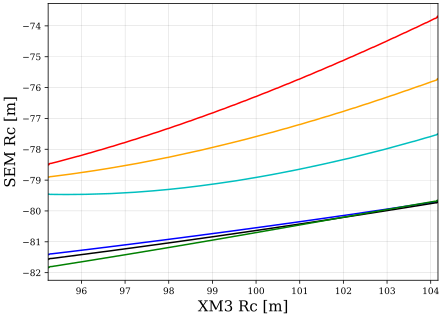

In [88]:
fig, ax = plt.subplots(figsize=(7, 5))

kat1 = katt.deepcopy()
ITMX_TO_SEM1 = kat1.path(kat1.ITMX.p1, kat1.SEM.p1)
pb_SEC1 = kat1.propagate_beam(path=ITMX_TO_SEM1, symbolic=True)
Rc = pb_SEC1.q(kat1.SEM.p1.i).Rc

xrange = np.linspace(-0.04, 0.05, 150)
XM3S_range = (1/100)*(1 + xrange)
XM3Rc_range = 1/XM3S_range

for idx, line in enumerate(contour_lines):
    if 0<=idx<=1:
        XM2Rc = -10.4
    elif 2<=idx<=3:
        XM2Rc = -9.6
    else:
        XM2Rc = -8.8
        
    XM3Rc, LXM2_XM3 = line[:,0], line[:,1]
    Rc_evals = Rc.eval(subs={'lXM2_XM3.L': LXM2_XM3, 'XM3.Rcx': XM3Rc, 'XM2.Rcx': XM2Rc})

    ax.plot(np.linspace(min(XM3Rc_range), max(XM3Rc_range), len(Rc_evals)), Rc_evals)
    
ax.set_ylabel("SEM Rc [m]", fontsize=15) 
ax.set_xlabel("XM3 Rc [m]", fontsize=15);

[ 0.50389126 -5.27060101]
[ 0.501982   -4.96373103]
[ 0.50420772 -4.92158392]
[ 0.50164668 -4.5805255 ]
[ 0.50528337 -4.6423802 ]
[ 0.50059247 -4.12642907]


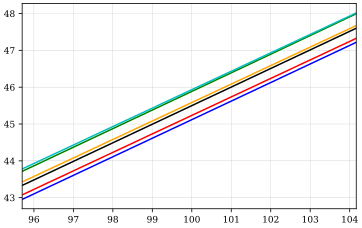

In [15]:
for line in contour_lines:
    XM3Rc, LXM2_XM3 = line[:,0], line[:,1]
    plt.plot(XM3Rc, LXM2_XM3)
    
def func(x, a, b):
    return a*x+b

popts = []
for idx, line in enumerate(contour_lines):
    XM3Rc, LXM2_XM3 = line[:,0], line[:,1]
    popt, pcov = curve_fit(func, XM3Rc, LXM2_XM3)
    popts.append(popt)
    print(popt)
# ["10.4 m", "9.6 m", "8.8 m"]

In [54]:
def line_104_1(x):
    return x*popts[0][0]+popts[0][1]
def line_104_2(x):
    return x*popts[1][0]+popts[1][1]

def line_96_1(x):
    return x*popts[2][0]+popts[2][1]
def line_96_2(x):
    return x*popts[3][0]+popts[3][1]

def line_88_1(x):
    return x*popts[4][0]+popts[4][1]
def line_88_2(x):
    return x*popts[5][0]+popts[5][1]

# plt.plot(XM3Rc_range,line_88_1(XM3Rc_range))
# plt.plot(XM3Rc_range,line_88_2(XM3Rc_range));

In [19]:
def func_XM3R_lXM2_XM3(lXM2_XM3, args):
    XM3_Rc, XM2_Rc = args

    kat1 = katt.deepcopy()
    kat1.lXM2_XM3.L = lXM2_XM3
    kat1.XM3.Rc = XM3_Rc 
    kat1.XM2.Rc = XM2_Rc
    
    trace1 = kat1.beam_trace()
    SEMRC = trace1[kat1.SEM.p1.i].qx.Rc
    # print(abs(SEMRC-SEM_Rc_fixed))

    return abs(SEMRC-SEM_Rc_fixed)

In [55]:
res = minimize(func_XM3R_lXM2_XM3, x0=line_104_1(110), args=[110, -10.4], method='BFGS', tol=1e-5)
res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 5.175895054776447e-06
        x: [ 5.016e+01]
      nit: 1
      jac: [ 6.424e+01]
 hess_inv: [[ 3.113e-06]]
     nfev: 58
     njev: 23

In [165]:
xrange = np.linspace(-0.04, 0.05, 50)
XM3S_range = (1/100)*(1 + xrange)
XM3Rc_range = 1/XM3S_range[::-1]
    
def ParaSpaceSearch(XM2Rc=-9.6):
    if XM2Rc==-9.6:
        line_func1 = line_96_1
        line_func2 = line_96_2
    elif XM2Rc==-8.8:
        line_func1 = line_88_1
        line_func2 = line_88_2
    elif XM2Rc==-10.4:
        line_func1 = line_104_1
        line_func2 = line_104_2

    lXM2_XM3_range_1 = []
    Gouy_SEC_range_1 = []
    w_SEM_range_1 = []
    w_BS_range_1 = []
    
    lXM2_XM3_range_2 = []
    Gouy_SEC_range_2 = []
    w_SEM_range_2 = []
    w_BS_range_2 = []

    for idx, XM3Rc in enumerate(XM3Rc_range):   
        x0 = line_func1(XM3Rc)
        rangee = 1.6e-3
        if XM3Rc>103:
            rangee = 0.7e-3
        bnds = (x0*(1-rangee), x0*(1+rangee)),
        res = minimize(func_XM3R_lXM2_XM3, x0=x0, args=[XM3Rc, XM2Rc], method='Nelder-Mead', tol=1e-5, bounds=bnds,)

        if res.success and res.fun<0.1:
            lXM2_XM3_range_1.append(res.x)

            kat2 = katt.deepcopy()
            kat2.lXM2_XM3.L = res.x
            kat2.XM3.Rc = XM3Rc
            kat2.XM2.Rc = XM2Rc

            ITMX_TO_SEM = kat2.path(kat2.ITMX.p1, kat2.SEM.p1)
            pb_SEC = kat2.propagate_beam(path=ITMX_TO_SEM)

            Gouy_SEC = pb_SEC.acc_gouy("lXM3_ITMXlens", "lXM2_XM3", "lBS_XM2", "lBS_SEM")
            Gouy_SEC_range_1.append(Gouy_SEC)

            w_SEM_range_1.append(pb_SEC.q(kat2.SEM.p1.i).w)
            w_BS_range_1.append(pb_SEC.q(kat2.BS.p3.i).w)
        else:
            print(f"Can't find a optimization solution when XM3 Rc={XM3Rc:.2f}")
            
        # if idx!=0 and idx%12 == 0:
        #     print("A quarter of the function call is finished...")
            
            
    # for idx, XM3Rc in enumerate(XM3Rc_range): 
        x0 = line_func2(XM3Rc)
        rangee = 1.6e-3
        if XM3Rc>100:
            rangee = 1.1e-3
        if XM3Rc>103:
            rangee = 0.7e-3
        bnds = (x0*(1-rangee), x0*(1+rangee)),
        res = minimize(func_XM3R_lXM2_XM3, x0=x0, args=[XM3Rc, XM2Rc], method='Nelder-Mead', tol=1e-5, bounds=bnds,)

        if res.success and res.fun<0.1:
            lXM2_XM3_range_2.append(res.x)

            kat2 = katt.deepcopy()
            kat2.lXM2_XM3.L = res.x
            kat2.XM3.Rc = XM3Rc
            kat2.XM2.Rc = XM2Rc

            ITMX_TO_SEM = kat2.path(kat2.ITMX.p1, kat2.SEM.p1)
            pb_SEC = kat2.propagate_beam(path=ITMX_TO_SEM)

            Gouy_SEC = pb_SEC.acc_gouy("lXM3_ITMXlens", "lXM2_XM3", "lBS_XM2", "lBS_SEM")
            Gouy_SEC_range_2.append(Gouy_SEC)

            w_SEM_range_2.append(pb_SEC.q(kat2.SEM.p1.i).w)
            w_BS_range_2.append(pb_SEC.q(kat2.BS.p3.i).w)
        else:
            print(f"Can't find a optimization solution when XM3 Rc={XM3Rc:.2f}")
            
        if idx!=0 and idx%12 == 0:
            print("A quarter of the function call is finished...")
            
    return  (lXM2_XM3_range_1, Gouy_SEC_range_1, w_SEM_range_1, w_BS_range_1), (lXM2_XM3_range_2, Gouy_SEC_range_2, \
                                                                                w_SEM_range_2, w_BS_range_2)   

In [176]:
lXM2_XM3_ranges = []
Gouy_SEC_ranges = []
w_SEM_ranges = []
w_BS_ranges = []

for XM2Rc in [-10.4, -9.6, -8.8]:
    (lXM2_XM3_range_1, Gouy_SEC_range_1, w_SEM_range_1, w_BS_range_1), \
    (lXM2_XM3_range_2, Gouy_SEC_range_2, w_SEM_range_2, w_BS_range_2) = ParaSpaceSearch(XM2Rc=XM2Rc)
    
    lXM2_XM3_ranges.append(lXM2_XM3_range_1)
    lXM2_XM3_ranges.append(lXM2_XM3_range_2) 
    
    Gouy_SEC_ranges.append(Gouy_SEC_range_1)
    Gouy_SEC_ranges.append(Gouy_SEC_range_2)
    
    w_SEM_ranges.append(w_SEM_range_1)
    w_SEM_ranges.append(w_SEM_range_2)
    
    w_BS_ranges.append(w_BS_range_1)
    w_BS_ranges.append(w_BS_range_2)
    print()

with open(r"./Saved/lXM2_XM3_ranges.pickle", "wb") as output_file:
    pickle.dump(lXM2_XM3_ranges, output_file)
    
with open(r"./Saved/Gouy_SEC_ranges.pickle", "wb") as output_file:
    pickle.dump(Gouy_SEC_ranges, output_file)
    
with open(r"./Saved/w_SEM_ranges.pickle", "wb") as output_file:
    pickle.dump(w_SEM_ranges, output_file)
    
with open(r"./Saved/w_BS_ranges.pickle", "wb") as output_file:
    pickle.dump(w_BS_ranges, output_file)

A quarter of the function call is finished...
A quarter of the function call is finished...
A quarter of the function call is finished...
A quarter of the function call is finished...

A quarter of the function call is finished...
A quarter of the function call is finished...
A quarter of the function call is finished...
A quarter of the function call is finished...

A quarter of the function call is finished...
A quarter of the function call is finished...
A quarter of the function call is finished...
A quarter of the function call is finished...



In [177]:
with open(r"./Saved/lXM2_XM3_ranges.pickle", "rb") as input_file:
    lXM2_XM3_ranges = pickle.load(input_file)
with open(r"./Saved/Gouy_SEC_ranges.pickle", "rb") as input_file:
    Gouy_SEC_ranges = pickle.load(input_file)
with open(r"./Saved/w_SEM_ranges.pickle", "rb") as input_file:
    w_SEM_ranges = pickle.load(input_file)
with open(r"./Saved/w_BS_ranges.pickle", "rb") as input_file:
    w_BS_ranges = pickle.load(input_file)

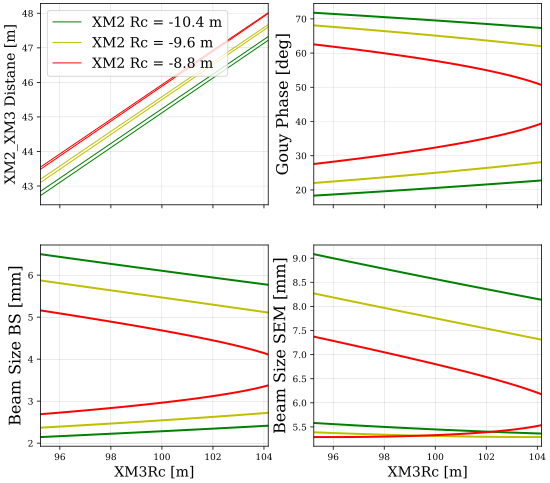

In [184]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(9, 8))

colors = ["g", "y", "r"]
XM2Rcs = [-10.4, -9.6, -8.8]
for idx, (lXM2_XM3, Gouy_SEC, w_SEM, w_BS) in enumerate(zip(lXM2_XM3_ranges, Gouy_SEC_ranges, w_SEM_ranges, w_BS_ranges)):
    ax1.plot(XM3Rc_range, lXM2_XM3, color=colors[idx//2], lw=1, label=f"XM2 Rc = {XM2Rcs[idx//2]} m" if idx%2==0 else "")
    ax2.plot(XM3Rc_range, Gouy_SEC, color=colors[idx//2], lw=2)
    ax3.plot(XM3Rc_range, np.array(w_SEM)*1e3, color=colors[idx//2], lw=2)
    ax4.plot(XM3Rc_range, np.array(w_BS)*1e3, color=colors[idx//2], lw=2)

ax3.set_xlabel("XM3Rc [m]", fontsize=14)
ax4.set_xlabel("XM3Rc [m]", fontsize=14)

ax1.set_ylabel("XM2_XM3 Distane [m]", fontsize=14);
ax2.set_ylabel("Gouy Phase [deg]", fontsize=16)
ax3.set_ylabel("Beam Size BS [mm]", fontsize=16)
ax4.set_ylabel("Beam Size SEM [mm]", fontsize=16);

ax1.legend(fontsize=14);

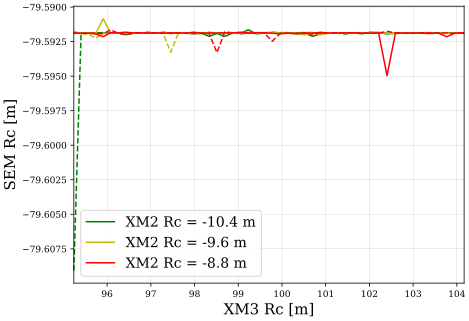

In [181]:
fig, ax = plt.subplots(figsize=(7, 5))

kat1 = katt.deepcopy()
ITMX_TO_SEM1 = kat1.path(kat1.ITMX.p1, kat1.SEM.p1)
pb_SEC1 = kat1.propagate_beam(path=ITMX_TO_SEM1, symbolic=True)
Rc = pb_SEC1.q(kat1.SEM.p1.i).Rc

for idx, lXM2_XM3 in enumerate(lXM2_XM3_ranges):
    Rc_evals = Rc.eval(subs={'lXM2_XM3.L': np.array(lXM2_XM3)[:,0], 'XM3.Rcx': np.array(XM3Rc_range), 'XM2.Rcx': XM2Rcs[idx//2]})

    ax.plot(XM3Rc_range, Rc_evals, label=f"XM2 Rc = {XM2Rcs[idx//2]} m" if idx%2==0 else "", color=colors[idx//2], ls="-" if idx%2==0 else "--")
    
ax.set_ylabel("SEM Rc [m]", fontsize=15) 
ax.set_xlabel("XM3 Rc [m]", fontsize=15)

ax.legend(fontsize=14);